# An ArrayParameter Example with Dual Setpoints

In this example we consider a dummy instrument that can return a time trace or the DFT (magnitude square) of that trace. The setpoints are accounted for in an easy way.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qcodes.instrument.base import Instrument, Parameter
from qcodes.instrument.parameter import ArrayParameter2
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, load_by_id

In [2]:
def timetrace(npts: int, dt: float) -> np.ndarray:
    """
    A very realistic-looking signal
    """
    #freq = 10/(dt*npts)
    #decay = 1/(dt*npts)
    freq = 10
    decay = 1
    time = np.linspace(0, npts*dt, npts, endpoint=False)
    signal = np.exp(-decay*time)*np.sin(2*np.pi*freq*time)
    noise = 0.1*np.random.randn(npts)
    return signal + noise

In [3]:


class TimeTrace(ArrayParameter2):
    
    def get_raw(self):
        npts = self.root_instrument.npts()
        dt = self.root_instrument.dt()
        
        return timetrace(npts, dt)
    

class Periodogram(ArrayParameter2):
    
    def get_raw(self):
        npts = self.root_instrument.npts()
        dt = self.root_instrument.dt()
        
        tt = self.root_instrument.trace()
        
        return np.abs(np.fft.fft(tt))**2
        
        
class TimeAxis(Parameter):

    def get_raw(self):
        npts = self.root_instrument.npts()
        dt = self.root_instrument.dt()
        return np.linspace(0, dt*npts, npts, endpoint=False)

    
class FrequencyAxis(Parameter):
    
    def get_raw(self):
        npts = self.root_instrument.npts()
        dt = self.root_instrument.dt()

        return np.linspace(0, 1/dt, npts)
    
        
class OzzyLowScope(Instrument):
    
    def __init__(self, name, **kwargs):
        
        super().__init__(name, **kwargs)
        
        self.add_parameter(name='npts',
                           initial_value=500,
                           label='Number of points',
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter(name='dt',
                           initial_value=1e-3,
                           label='Time resolution',
                           unit='s',
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter(name='time_axis',
                           label='Time',
                           unit='s',
                           parameter_class=TimeAxis)
        
        self.add_parameter(name='freq_axis',
                           label='Frequency',
                           unit='Hz',
                           parameter_class=FrequencyAxis)
        
        self.add_parameter(name='trace',
                           label='Signal',
                           unit='V',
                           setpoints=(self.time_axis,),
                           parameter_class=TimeTrace)
        
        self.add_parameter(name='periodogram',
                           label='Periodogram',
                           unit='V^2/Hz',
                           setpoints=(self.freq_axis,),
                           parameter_class=Periodogram)

In [4]:
osc = OzzyLowScope('osc')

## Measurement 1: Time Trace

In [5]:
timemeas = Measurement()
timemeas.register_parameter(osc.trace)

osc.dt(0.001)

with timemeas.run() as datasaver:
    datasaver.add_result((osc.trace, osc.trace.get()))
    
dataid = datasaver.run_id

Starting experimental run with id: 101


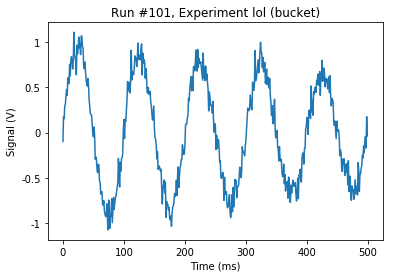

In [6]:
_ = plot_by_id(dataid)

In [7]:
osc.dt(0.01)  # make the trace 10 times longer

with timemeas.run() as datasaver:
    datasaver.add_result((osc.trace, osc.trace.get()))
    
dataid = datasaver.run_id

Starting experimental run with id: 102


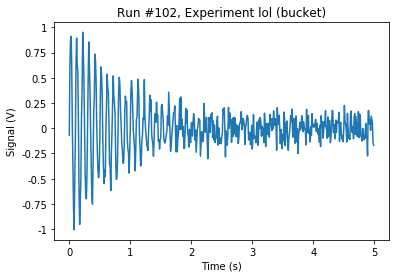

In [8]:
_ = plot_by_id(dataid)

## Measurement 2: Periodogram

In [9]:
freqmeas = Measurement()
freqmeas.register_parameter(osc.periodogram)

osc.dt(0.01)

with freqmeas.run() as datasaver:
    datasaver.add_result((osc.periodogram, osc.periodogram.get()))
    
dataid = datasaver.run_id

Starting experimental run with id: 103


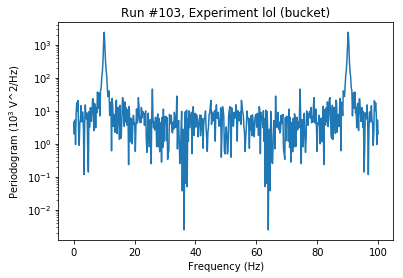

In [10]:
axs, cbax = plot_by_id(dataid)
aa = axs[0]
aa.set_yscale('log')

Just for the fun of it, let's make a measurement with the averaged periodogram.

In [11]:
no_of_avgs = 100

with freqmeas.run() as datasaver:
    
    temp_per = osc.periodogram()
    
    for _ in range(no_of_avgs-1):
        temp_per += osc.periodogram()
        
    datasaver.add_result((osc.periodogram, temp_per/no_of_avgs))

dataid = datasaver.run_id

Starting experimental run with id: 104


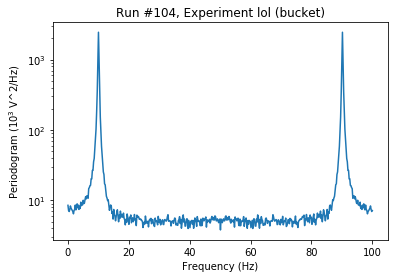

In [12]:
axs, cbax = plot_by_id(dataid)
aa = axs[0]
aa.set_yscale('log')

## Measurement 3: 2D Sweeping

In [13]:
meas = Measurement()
meas.register_parameter(osc.npts)
meas.register_parameter(osc.trace, setpoints=[osc.npts])

with meas.run() as datasaver:

    osc.dt(0.001)
    
    for npts in [200, 400, 600, 800, 1000, 1200]:
        osc.npts(npts)
        datasaver.add_result((osc.trace, osc.trace()),
                             (osc.npts, osc.npts()))
        
dataid = datasaver.run_id

Starting experimental run with id: 105


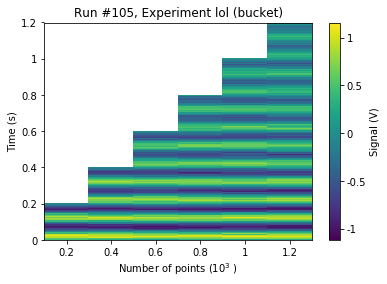

In [14]:
_ = plot_by_id(dataid)